#### Estudo de Correlação 
> Temperatura / Cobertura Vegetal
  
<sub>gds - Google Dataset</sub>  
<sub>lz - Listed Zeros</sub>  
<sub>corr - Correlation</sub>  
<sub>avr - Average</sub> 

---  

In [1]:
# Importing GEE dependencies
from helpers.geeApi import PrecorsiaGee
import ee

# Importing image processing tools
from helpers.imageCorrelator import ImageCorrelator
from helpers.imageProcessor import ImageProcessor

#### Image availability list

Add dataset's configuration 

In [2]:
# ! Execute once per session
PrecorsiaGee.init()

In [3]:
START, END = PrecorsiaGee.date_daily('2020-01-01', 730)
geolocation = [16.0569, 51.6608]
image_scale = 10000
round_factor = 8

In [4]:
reference_dataset = 'GOOGLE/DYNAMICWORLD/V1'
comparable_dataset = 'COPERNICUS/S5P/NRTI/L3_CLOUD'

reference_band_name, reference_band_range = 'grass', [0, 1]
comparable_band_name, comparable_band_range = 'surface_albedo', [0, 1]

In [5]:
gds_one = PrecorsiaGee(reference_dataset, reference_band_range)
gds_two = PrecorsiaGee(comparable_dataset, comparable_band_range)

Configure the filter and get the list of images

In [6]:
gds_one_list = gds_one.list(geolocation, [START, END])
gds_two_list = gds_two.list(geolocation, [START, END])
gds_one_list, gds_two_list = PrecorsiaGee.correlate_dates(gds_one_list, gds_two_list, round_factor)

#### Image requests and data acquisition

commit to memory

In [20]:
PrecorsiaGee.download_images(gds_one_list, gds_one, reference_band_name, geolocation, image_scale)
PrecorsiaGee.download_images(gds_two_list, gds_two, comparable_band_name, geolocation, image_scale)

GOOGLE/DYNAMICWORLD/V1 Progress: 100.00% | Estimated time: 0.00s

COPERNICUS/S5P/NRTI/L3_CLOUD Progress: 100.00% | Estimated time: 0.00s



#### Processing and visualizing the data

filter using zero counting

In [8]:
# ! will delete from buffer
process = ImageProcessor([gds_one_list, gds_two_list])
[gds_one_lz, gds_two_lz] = process.zero_counting_filter()

Group by date and plot a correlation graph

In [9]:
corr_list = PrecorsiaGee.connected_correlation(gds_one_lz, gds_two_lz, round_factor)

In [10]:
title = {'title': f'Correlation between {gds_one.dataset} and {gds_two.dataset} at {geolocation}',
         'xlabel': gds_one.dataset, 'ylabel': gds_two.dataset}

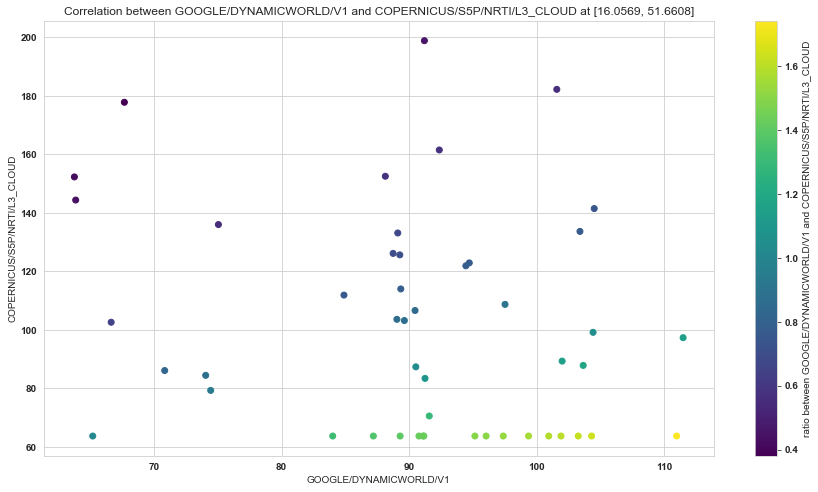

In [11]:
corr_study = ImageCorrelator(corr_list)
corr_avr = corr_study.calculate_correlation()
ImageCorrelator.plot(corr_avr, title)
plt.show()